###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D Shallow Water Equations

[In the last class](https://github.com/daniel-koehn/Differential-equations-earth-system/tree/master/09_Navier_Stokes_2D\#lecture-9-2d-navier-stokes-equations), we modelled fluid flow problems by solving the 2D Navier-Stokes equations.

In this lecture, we will use an approximation to the Navier-Stokes equations - the 2D Shallow Water equations - in order to model the propagation of Tsunamis.

## Governing Equations

Starting from the continuity and momentum conservation equations, we want to solve the following problem:

<img src="images/shallow_water_sketch.png" style="width: 500px;"/>

For a given bathymetry model, which can include a complex seafloor topography, we want to model the amplitudes, speed and interaction of waves at the seasurface. At a given point $(x,\; y)$, the thickness of the water column between the seafloor and undisturbed water surface is defined by the variable $h$, while the wave amplitude is $\eta$ and therefore the whole thickness of the water column $D = h + \eta$.

Using appropriate boundary conditions at the water surface/seafloor, assuming that the horizontal wavelength of the modelled waves are much larger than the water depth and integrating the conservation of mass and momentum equations over the water column, we can derive the following equations to decribe wave propagation 

\begin{equation}
\begin{split}
\frac{\partial \eta}{\partial t} &+ \frac{\partial M}{\partial x} + \frac{\partial N}{\partial y} = 0\\
\frac{\partial M}{\partial t} &+ \frac{\partial}{\partial x} \biggl(\frac{M^2}{D}\biggr) + \frac{\partial}{\partial y} \biggl(\frac{MN}{D}\biggr) + g D \frac{\partial \eta}{\partial x} + \frac{g \alpha^2}{D^{7/3}} M \sqrt{M^2+N^2} = 0\\
\frac{\partial N}{\partial t} &+ \frac{\partial}{\partial x} \biggl(\frac{MN}{D}\biggr) + \frac{\partial}{\partial y} \biggl(\frac{N^2}{D}\biggr) + g D \frac{\partial \eta}{\partial y} + \frac{g \alpha^2}{D^{7/3}} N \sqrt{M^2+N^2} = 0
\end{split}
\tag{1}
\end{equation}

known as **2D Shallow Water Equations (SWE)**. The derivation of these equations is beyond the scope of this notebook. Therefore, I refer to the [Tsunami Modelling Handbook](http://www.tsunami.civil.tohoku.ac.jp/hokusai3/J/projects/manual-ver-3.1.pdf) and the lecture [Shallow Water Derivation and Applications by Christian Kühbacher](http://www.mathematik.tu-dortmund.de/lsiii/cms/papers/Kuehbacher2009.pdf) for further details.

In eqs. (1) the discharge fluxes $M,\; N$ in x- and y-direction, respectively are given by

\begin{equation}
\begin{split}
M & = \int_{-h}^\eta u dz = u(h+\eta) = uD\\
N & = \int_{-h}^\eta v dz = v(h+\eta) = vD\\
\end{split}
\tag{2}
\end{equation}

with the horizontal velocity components $u,\;v$ in x- and y-direction, while $g$ denotes the gravity acceleration. The terms $\frac{g \alpha^2}{D^{7/3}} M \sqrt{M^2+N^2}$ and $\frac{g \alpha^2}{D^{7/3}} N \sqrt{M^2+N^2}$ describe the influence of seafloor friction on the wave amplitude. $\alpha$ denotes the Manning's roughness which can be as small as 0.01 for neat cement or smooth metal up to 0.06 for very poor natural channels (see [Tsunami modelling handbook](http://www.tsunami.civil.tohoku.ac.jp/hokusai3/J/projects/manual-ver-3.1.pdf)).

The Shallow Water Equations can be applied to 

- Tsunami prediction
- Atmospheric flow
- Storm surges
- Flows around structures
- Planetary flows

and easily extended to incorporate the effects of Coriolis forces, tides or wind stress.

In order to solve the Shallow Water Equations (1), we will use the finite difference method. So lets directly start with coding. As usual, we begin by importing some basic Python libraries and set up the plotting environment.

In [2]:
# Import libraries
import numpy
from matplotlib import pyplot
from scipy.ndimage import gaussian_filter
%matplotlib inline

# import JIT from Numba
from numba import jit

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

##  Finite-Difference solution of 2D Shallow Water Equations

First, we write three functions `update_eta_2D`, `update_M_2D`, `update_N_2D` which solve eqs. (1) by the finite-difference method. In this implementation the time derivatives are approximated by forward operators, while we use central operators for the spatial derivatives. To optimize the runtime of the functions, we use `Just-In-Time (JIT)` compilation from the `Numba` package.

##### Exercise

Before moving on, try to write down the finite difference approximations for eqs. (1) by yourself using the aforementioned FD operators.

In [4]:
# Update Eta field
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def update_eta_2D(eta, M, N, dx, dy, dt, nx, ny):
    
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            
            # compute spatial derivatives
            dMdx = (M[j,i+1] - M[j,i-1]) / (2. * dx)
            dNdy = (N[j+1,i] - N[j-1,i]) / (2. * dy)
            
            # update eta field using leap-frog method
            eta[j, i] = eta[j, i] - dt * (dMdx + dNdy)
    
    # apply Neumann boundary conditions for eta at all boundaries
    eta[0,:] = eta[1,:]
    eta[-1,:] = eta[-2,:]
    eta[:,0] = eta[:,1]
    eta[:,-1] = eta[:,-2]
    
    return eta          

In [5]:
# Update M field
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def update_M_2D(eta, M, N, D, g, h, alpha, dx, dy, dt, nx, ny):
    
    # compute argument 1: M**2/D + 0.5 * g * eta**2
    arg1 = M**2 / D
    
    # compute argument 2: M * N / D
    arg2 = M * N / D
    
    # friction term
    fric = g * alpha**2 * M * numpy.sqrt(M**2 + N**2) / D**(7./3.)
    
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,ny-1):            
            
            # compute spatial derivatives
            darg1dx = (arg1[j,i+1] - arg1[j,i-1]) / (2. * dx)
            darg2dy = (arg2[j+1,i] - arg2[j-1,i]) / (2. * dy)
            detadx = (eta[j,i+1] - eta[j,i-1]) / (2. * dx)
            
            # update M field using leap-frog method
            M[j, i] = M[j, i] - dt * (darg1dx + darg2dy + g * D[j,i] * detadx + fric[j,i])
            
    return M           

In [6]:
# Update N field
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def update_N_2D(eta, M, N, D, g, h, alpha, dx, dy, dt, nx, ny):
    
    # compute argument 1: M * N / D
    arg1 = M * N / D
    
    # compute argument 2: N**2/D + 0.5 * g * eta**2    
    arg2 = N**2 / D
    
    # friction term
    fric = g * alpha**2 * N * numpy.sqrt(M**2 + N**2) / D**(7./3.)
    
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,ny-1):            
            
            # compute spatial derivatives
            darg1dx = (arg1[j,i+1] - arg1[j,i-1]) / (2. * dx)
            darg2dy = (arg2[j+1,i] - arg2[j-1,i]) / (2. * dy)
            detady = (eta[j+1,i] - eta[j-1,i]) / (2. * dy)
            
            # update N field using leap-frog method
            N[j, i] = N[j, i] - dt * (darg1dx + darg2dy + g * D[j,i] * detady + fric[j,i])
                        
    return N          

Now comes the most important part, we write the `Shallow_water_2D` code, where the solutions of the functions `update_eta_2D`, `update_M_2D`, `update_N_2D` are assembled. During the solution of the shallow water problem, we visualize the wave height and bathymetry using the `imshow` function and write the results as `TIFF` images into the folder `image_out`. This requires to set the plotting routine to interactive mode, which is NOT possible in JupyterLab. Therefore, the code will NOT run in JupyterLab. The `TIFF` images can later be compiled to a time-lapse movie.

In [7]:
# 2D Shallow Water Equation code with JIT optimization
# -------------------------------------------------------
def Shallow_water_2D(eta0, M0, N0, h, g, alpha, nt, dx, dy, dt, X, Y):
    
    """
    Computes and returns the discharge fluxes M, N and wave height eta from 
    the 2D Shallow water equation using the FTCS finite difference method.
    
    Parameters
    ----------
    eta0 : numpy.ndarray
        The initial wave height field as a 2D array of floats.
    M0 : numpy.ndarray
        The initial discharge flux field in x-direction as a 2D array of floats.    
    N0 : numpy.ndarray
        The initial discharge flux field in y-direction as a 2D array of floats.    
    h : numpy.ndarray
        Bathymetry model as a 2D array of floats.
    g : float
        gravity acceleration.
    alpha : float
        Manning's roughness coefficient.
    nt : integer
        Number fo timesteps.
    dx : float
        Spatial gridpoint distance in x-direction.
    dy : float
        Spatial gridpoint distance in y-direction.        
    dt : float
        Time step. 
    X : numpy.ndarray
        x-coordinates as a 2D array of floats.
    Y : numpy.ndarray
        y-coordinates as a 2D array of floats.
    
    Returns
    -------
    eta : numpy.ndarray
        The final wave height field as a 2D array of floats.
    M : numpy.ndarray
        The final discharge flux field in x-direction as a 2D array of floats.    
    N : numpy.ndarray
        The final discharge flux field in y-direction as a 2D array of floats.  
    """    
    
    # Copy fields
    eta = eta0.copy()
    M = M0.copy()
    N = N0.copy()
    
    # Compute total thickness of water column D
    D = eta + h
    
    # Estimate number of grid points in x- and y-direction
    ny, nx = eta.shape
    
    # Define the locations along a gridline.
    x = numpy.linspace(0, nx*dx, num=nx)
    y = numpy.linspace(0, ny*dy, num=ny)
    
    # Plot the initial wave height fields eta and bathymetry model
    fig = pyplot.figure(figsize=(10., 6.))
    cmap = 'seismic'
    
    pyplot.tight_layout()
    extent = [numpy.min(x), numpy.max(x),numpy.min(y), numpy.max(y)]
    
    # Plot bathymetry model
    topo = pyplot.imshow(numpy.flipud(-h), cmap=pyplot.cm.gray, interpolation='nearest', extent=extent) 
    
    # Plot wave height field at current time step
    im = pyplot.imshow(numpy.flipud(eta), extent=extent, interpolation='spline36', cmap=cmap, alpha=.75, vmin = -0.4, vmax=0.4)

    pyplot.xlabel('x [m]')
    pyplot.ylabel('y [m]')
    cbar = pyplot.colorbar(im)
    cbar1 = pyplot.colorbar(topo)
    pyplot.gca().invert_yaxis()
    cbar.set_label(r'$\eta$ [m]')
    cbar1.set_label(r'$-h$ [m]')
    
    # activate interactive plot
    pyplot.ion()    
    pyplot.show(block=False)  
    
    # write wave height field and bathymetry snapshots every nsnap time steps to image file
    nsnap = 50
    snap_count = 0
    
    # Loop over timesteps
    for n in range(nt):
        
        # 1. Update Eta field
        # -------------------
        eta = update_eta_2D(eta, M, N, dx, dy, dt, nx, ny)
        
        # 2. Update M field
        # -----------------
        M = update_M_2D(eta, M, N, D, g, h, alpha, dx, dy, dt, nx, ny)
        
        # 3. Update N field
        # -----------------
        N = update_N_2D(eta, M, N, D, g, h, alpha, dx, dy, dt, nx, ny)
        
        # 4. Compute total water column D
        # -------------------------------
        D = eta + h
        
        # update wave height field eta
        if (n % nsnap) == 0:        
            im.set_data(eta)
            fig.canvas.draw()
            
            # write snapshots to Tiff files
            name_snap = "image_out/Shallow_water_2D_" + "%0.*f" %(0,numpy.fix(snap_count+1000)) + ".tiff"
            pyplot.savefig(name_snap, format='tiff', bbox_inches='tight', dpi=125)
            snap_count += 1
                    
    return eta, M, N

## Example I: Tsunami in an ocean with constant depth

After writing the `Shallow_water_2D` code and all the required functions attached to it, we can define and run our first 2D Tsunami modelling run.

Let's assume that the ocean model is $ L_x = 100\; m$ in x-direction and $L_y = 100\; m$ in y-direction. The model is discretized with $nx=401$ gridpoints in x-direction and $ny=401$ gridpoints in y-direction, respectively.

In this first modelling run, we assume a constant bathymetry $h=50\;m$. The initial wave height field $\eta_0$ is defined as a Gaussian at the center of the model, with a half-width of 10 m and an amplitude of 0.5 m. Regarding the initial discharge fluxes, we assume that 

\begin{equation}
\begin{split}
M_0(x,y) &= 100 \eta_0(x,y)\\
N_0(x,y) &= 0\\
\end{split}\notag
\end{equation}

Furthermore, Dirichlet boundary conditions for the discharge fluxes $M,\;N$ are assumed at all boundaries: 

\begin{equation}
\begin{split}
M(0,y) &= M(L_x,y) = M(x,0) = M(x,L_y) = 0\\  
N(0,y) &= N(L_x,y) = N(x,0) = N(x,L_y) = 0\\  
\end{split} \notag
\end{equation}

For the wave height field $\eta$, it is essential that Neumann boundary conditions are set at all boundaries:

\begin{equation}
\begin{split}
&\frac{\partial \eta}{\partial x}(0,y) = 0\\
&\frac{\partial \eta}{\partial x}(L_x,y) = 0\\
&\frac{\partial \eta}{\partial y}(x,0) = 0\\
&\frac{\partial \eta}{\partial y}(x,L_y) = 0\\
\end{split}\notag
\end{equation}

in order to avoid the occurence of high frequency artifacts, when waves are interacting with the boundaries. Notice, that the assumed boundary conditions lead to significant boundary reflections which might be not realistic for a given problem. However, to keep the problem simple, we will not try to mitigate the boundary reflections. 

In [16]:
# Definition of modelling parameters
# ----------------------------------
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h = 50 * numpy.ones_like(X)

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * numpy.exp(-((X-50)**2/10)-((Y-50)**2/10))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0

After defining the gravity acceleration $g$, friction coefficient $\alpha$, maximum propagation time $Tmax$, time step size $dt$ and number of timesteps $nt$, we can start the first modelling run ...

<IPython.core.display.Javascript object>


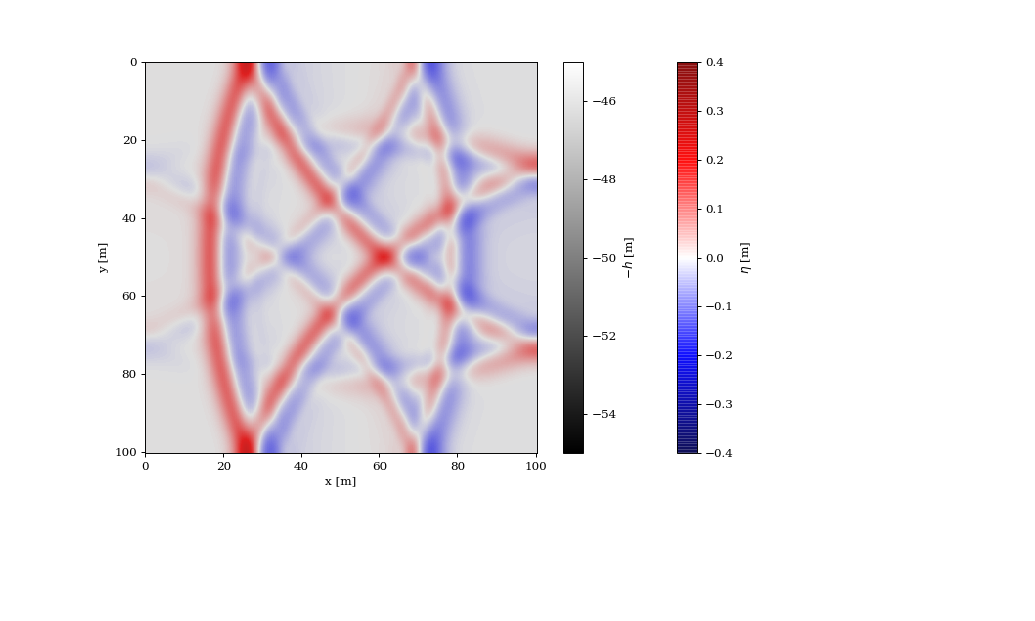

In [17]:
%matplotlib notebook

# define some constants
g = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax = 6.
dt = 1/4500.
nt = (int)(Tmax/dt)

# Compute eta, M, N fields
eta, M, N = Shallow_water_2D(eta0, M0, N0, h, g, alpha, nt, dx, dy, dt, X, Y)

After a runtime of roughly 15 minutes on my Desktop gaming PC (Intel Core i7-6700K CPU @ 4 GHz, 16 GB Ram), we can assemble the snapshots into the following movie:

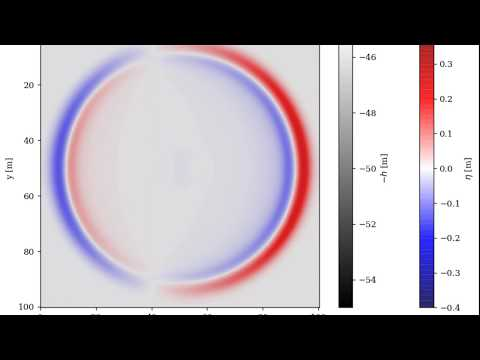

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('VtWbiVQ_u2Y')

Notice how the initial Gaussian function height collapses and waves with positive amplitudes travel to the right, while waves with negative amplitudes propagating to the left. When reaching the boundaries, the waves are reflected, which later interfere with each other, leading to a very complex wavefield.

## Example II: Two Tsunamis in an ocean with constant depth

In example II, we will model the propagation and interaction of two Tsunamis, where the initial conditions for the wave height field $\eta_0$ consists of Gaussian functions with opposite sign located at $(x_1,\;y_1) = (35\; m,\; 35\; m)$ and $(x_2,\;y_2) = (65\; m,\; 65\; m)$. All other modelling parameters remain the same ...

In [23]:
# Definition of modelling parameters
# ----------------------------------
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h = 50 * numpy.ones_like(X)

# Define initial Gaussian eta distribution [m]
eta0 = 0.5 * numpy.exp(-((X-35)**2/10)-((Y-35)**2/10)) # first Tsunami source
eta0 -= 0.5 * numpy.exp(-((X-65)**2/10)-((Y-65)**2/10)) # add second Tsunami source

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0

After running the code for 16 minutes, we get ...

<IPython.core.display.Javascript object>


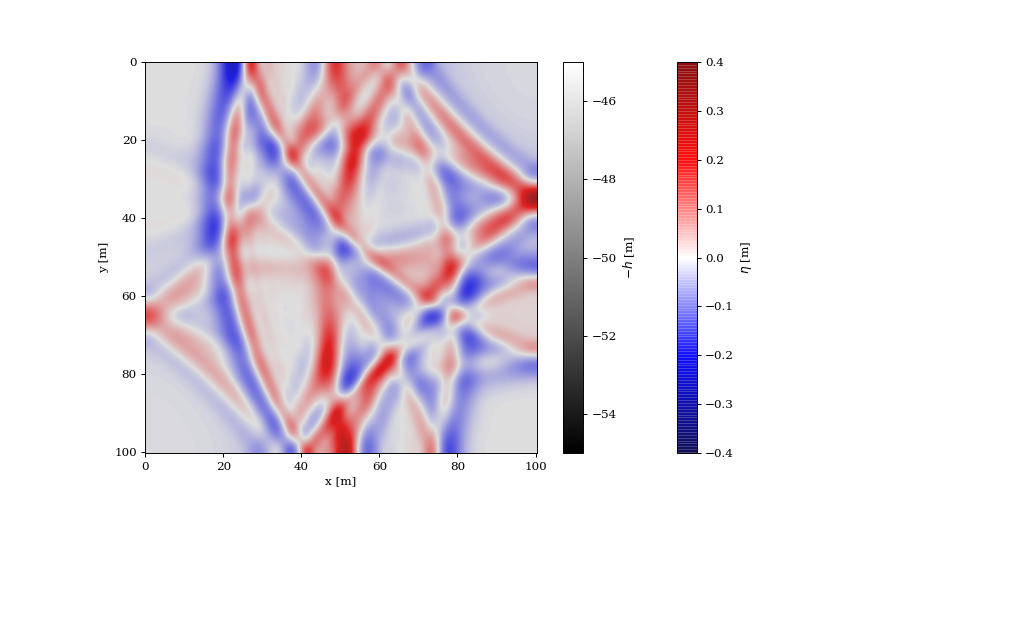

In [24]:
%matplotlib notebook

# define some constants
g = 9.81  # gravity accelaration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/8000.
nt = (int)(Tmax/dt)

# Compute eta, M, N fields
eta, M, N = Shallow_water_2D(eta0, M0, N0, h, g, alpha, nt, dx, dy, dt, X, Y)

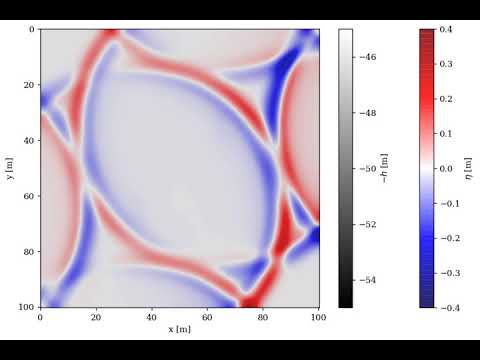

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('598DHY_8YWk')

... a solution, where the direct and reflected Tsunami wavefields are interfering with each other.

## Example III: Tsunami in an ocean with 1D Tanh depth variation

So far, so good, we can achieve stable and accurate modelling results. However, a constant bathymetry model is a little bit boring. In this example, we assume that the bathymetry decreases with a Tanh function from the left to the right boundary in x-direction. Let 's place a Tsunami source at $(x_1,\;y_1) = (30\; m,\; 50\; m)$ and see what 's happening ...

In [28]:
# Definition of modelling parameters
# ----------------------------------
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define depth profile h [m]
h = 50 - 45 * numpy.tanh((X-70.)/8.)

# Define initial eta [m]
eta0 = 0.5 * numpy.exp(-((X-30)**2/10)-((Y-50)**2/20))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0

... after waiting for 19 minutes ...

<IPython.core.display.Javascript object>


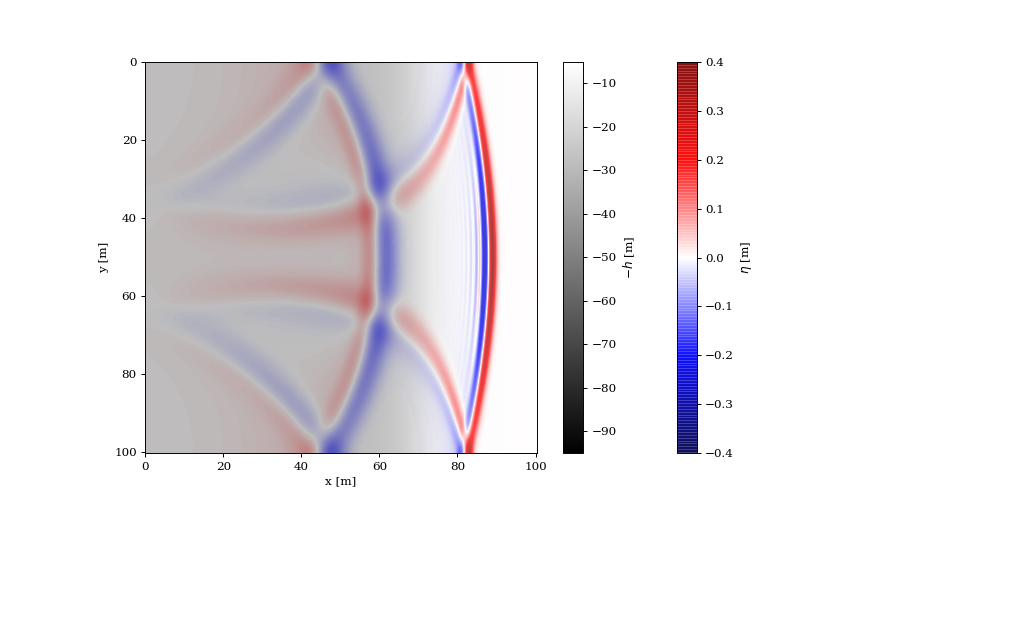

In [37]:
%matplotlib notebook

# define some constants
g = 9.81  # gravity accelaration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/8000.
nt = (int)(Tmax/dt)

# Compute eta, M, N fields
eta, M, N = Shallow_water_2D(eta0, M0, N0, h, g, alpha, nt, dx, dy, dt, X, Y)

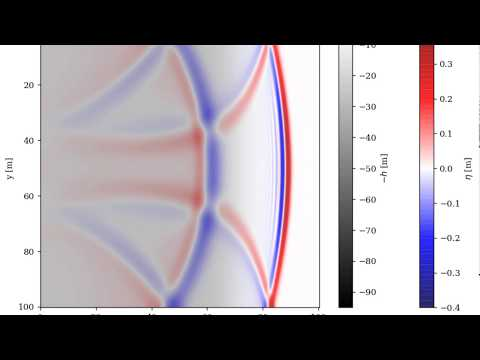

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('h2pPJSETvPI')

This looks interesting. Do you notice, how the wavelength of the Tsunami decreases as soon as it reaches the shallower bathymetry near the right boundary? The Tsunami also slows down, as you can see by comparing the velocity of the Tsunami with the reflection from the left model boundary. In the shallow water, the wave height also increases, which is more obvious when plotting a cut through the 2D wavefield at $y = 50\; m$:

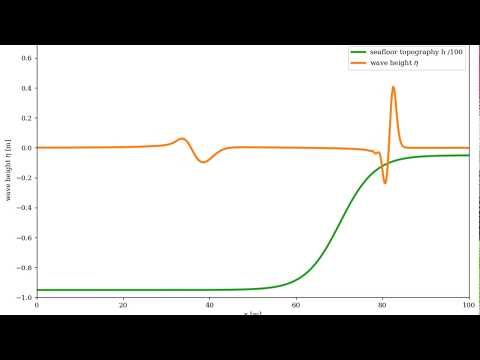

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('I6ynqyIGe2Q')

In summary, when the Tsunami reaches a cosatline, it slows down, its wavelength decreases and its amplitude increases. All these effects are the reason why Tsunamis have devastating effects, when reaching the coast.

## Example IV: Tsunami in an ocean with a seamount

What happens if we have a constant bathymetry, except for a small seamount reaching 5 m below the water surface? Lets define the model parameters ...

In [121]:
# Definition of modelling parameters
# ----------------------------------
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h = 50. * numpy.ones_like(X)

# Adding seamount to seafloor topography
h -= 45. * numpy.exp(-((X-50)**2/20)-((Y-50)**2/20))

# Define initial eta [m]
eta0 = 0.5 * numpy.exp(-((X-30)**2/5)-((Y-50)**2/5))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0

... run the code for 17 minutes ...

<IPython.core.display.Javascript object>


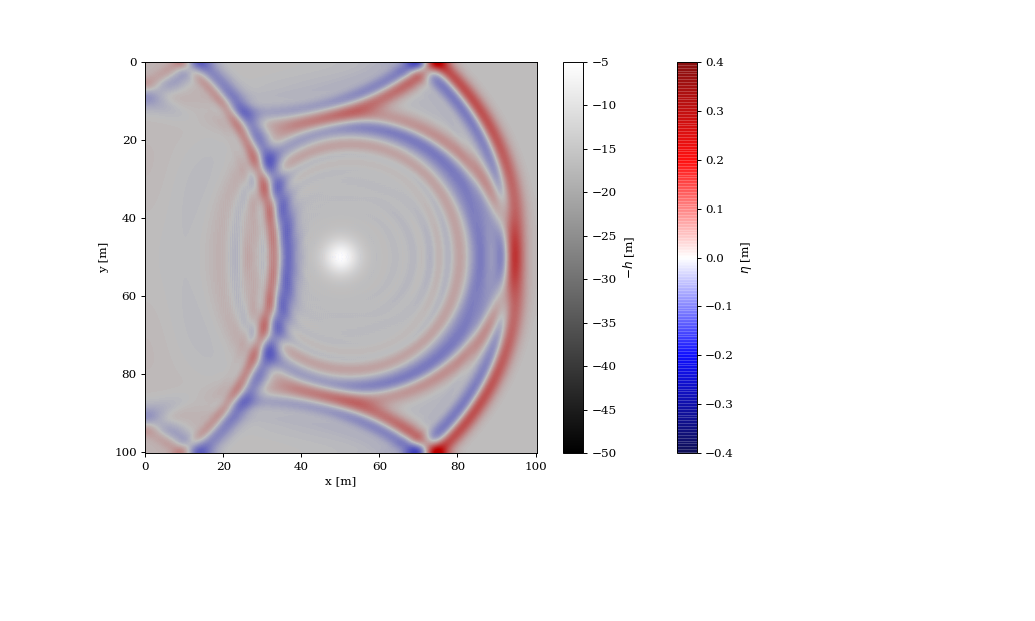

In [122]:
%matplotlib notebook

# define some constants
g = 9.81  # gravity accelaration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/8000.
nt = (int)(Tmax/dt)

# Compute eta, M, N fields
eta, M, N = Shallow_water_2D(eta0, M0, N0, h, g, alpha, nt, dx, dy, dt, X, Y)

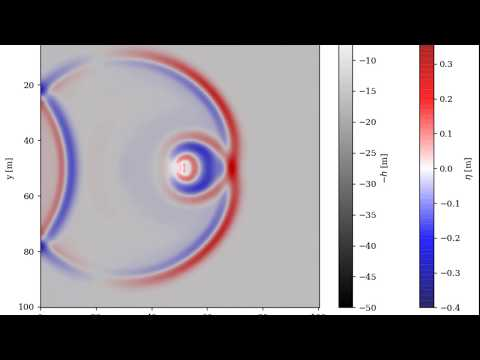

In [6]:
from IPython.display import YouTubeVideo
YouTubeVideo('BT7NN2KDt-s')

... and take a look at the resulting wavefield movie. Nothing spectacular happens, until the Tsunami reaches the seamount, which significantly scatters the Tsunami wavefield in all spatial directions.

## Example V: Tsunami in an ocean with random seafloor topography variations

Another modelling idea: what is the influence of the roughness of the seafloor topography. First, we add some random perturbations on the constant bathymetry model $h_0$ by using the `random.rand` function from the `NumPy` library. To smooth the random perturbations, we apply the `gaussian_filter` from the `SciPy`library:

In [109]:
# Definition of modelling parameters
# ----------------------------------
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 30 m
h0 = 30. * numpy.ones_like(X)

# Add random seafloor perturbation of +- 5m
pert = 5.   # perturbation amplitude
r = 2.0 * (numpy.random.rand(ny, nx) - 0.5) * pert # create random number perturbations
r = gaussian_filter(r, sigma=8) # smooth random number perturbation
h = h0 * (1 + r) # add perturbations to constant seafloor

# Define initial eta [m]
eta0 = 0.5 * numpy.exp(-((X-30)**2/5)-((Y-50)**2/5))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0

After running the code for 31 minutes ...

<IPython.core.display.Javascript object>


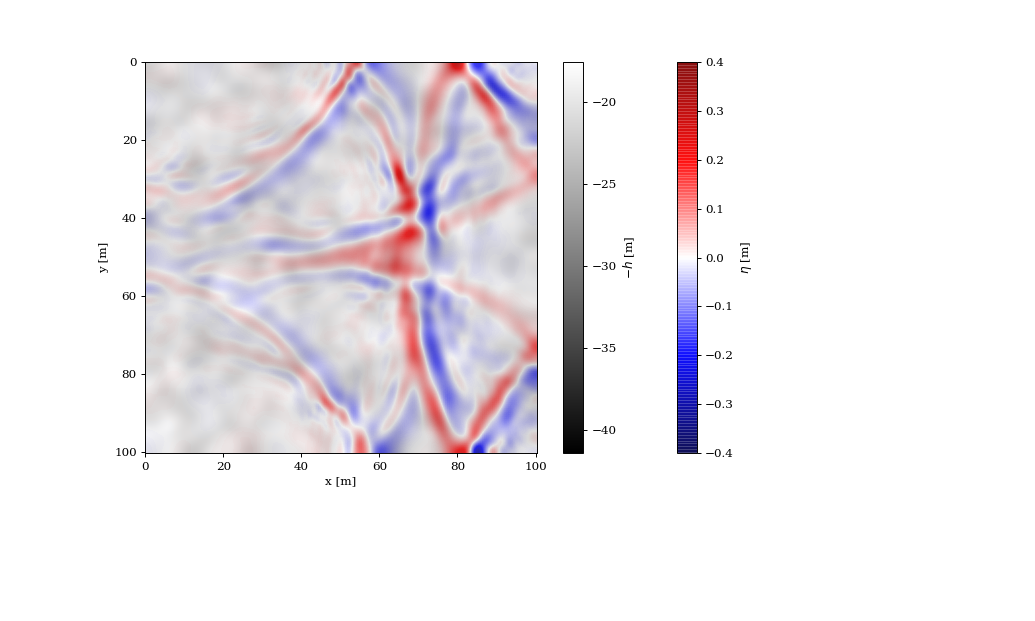

In [110]:
%matplotlib notebook

# define some constants
g = 9.81  # gravity accelaration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax = 6.
dt = 1/8000.
nt = (int)(Tmax/dt)

# Compute eta, M, N fields
eta, M, N = Shallow_water_2D(eta0, M0, N0, h, g, alpha, nt, dx, dy, dt, X, Y)

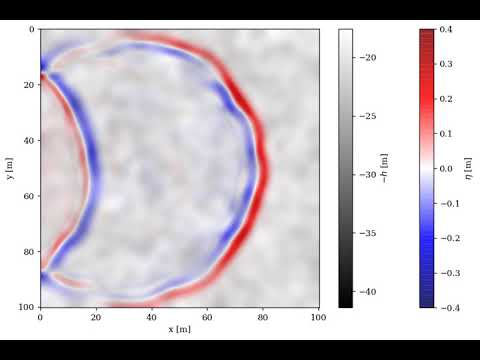

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('yxovuGEw754')

... we get a wavefield which at first glimpse looks like the solution for the constant bathymetry model. However, after some propagation time, you will notice how the rough seafloor topography locally perturbates the wavefield front.

## Example VI: 2D circular dam break problem

As a final modelling example, let's take a look at an (academic) engineering problem: a tsunami induced by the collapse of a circular dam in a lake with a constant bathymetry of 30 m. We only need to set the wave height in a circle with radius $r_0 = 5\; m$ to $\eta_0 = 0.5 \; m$ and to zero everywhere else. To avoid the occurence of high frequency artifacts in the wavefield, known as numerical grid dispersion, we apply a Gaussian filter to the initial wave height. To achieve a symmetric dam collapse, the initial discharge fluxes $M_0,N_0$ are set to equal values.

In [16]:
# Definition of modelling parameters
# ----------------------------------
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 30 m
h = 30. * numpy.ones_like(X)

# Define initial eta [m]
eta0 = numpy.zeros_like(X)

# Define mask for circular dam location with radius r0
r0 = 5.
mask = numpy.where(numpy.sqrt((X-50)**2 + (Y-50)**2) <= r0)

# Set wave height in dam to 0.5 m
eta0[mask] = 0.5

# Smooth dam boundaries with gaussian filter
eta0 = gaussian_filter(eta0, sigma=8) # smooth random number perturbation

# Define initial M and N
M0 = 1. * eta0
N0 = 1. * M0

After running the code for 13 minutes ...

<IPython.core.display.Javascript object>


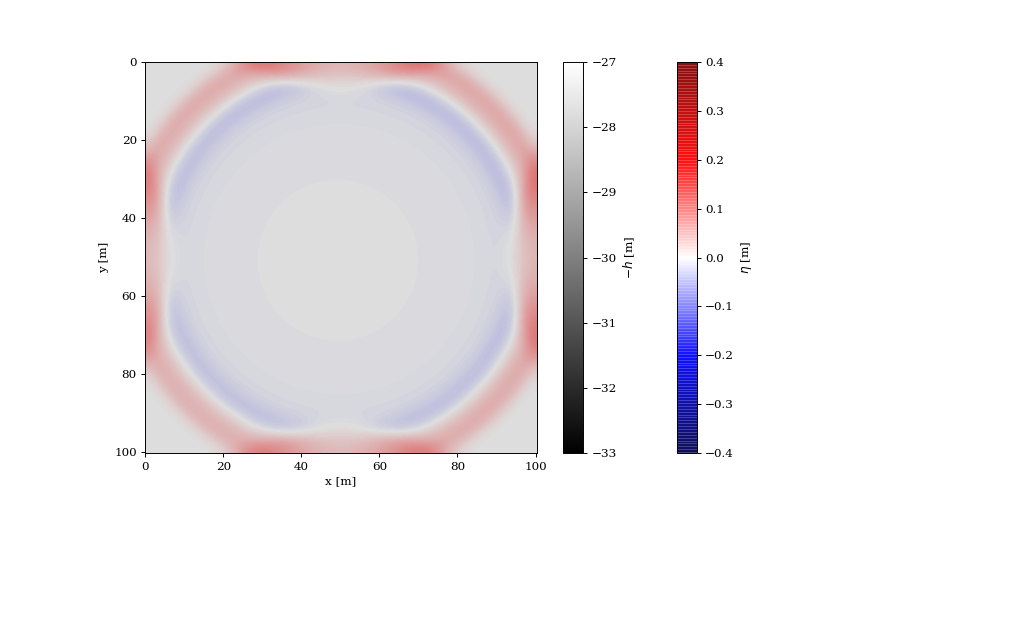

In [17]:
%matplotlib notebook

# define some constants
g = 9.81  # gravity accelaration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/8000.
nt = (int)(Tmax/dt)

# Compute eta, M, N fields
eta, M, N = Shallow_water_2D(eta0, M0, N0, h, g, alpha, nt, dx, dy, dt, X, Y)

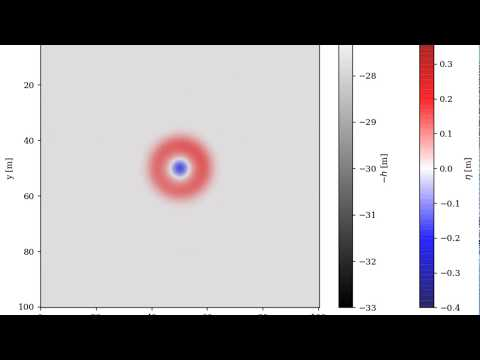

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('_8BOD_JS3oE')

... we get a symmetric, circular Tsunami wavefield induced by the symmetric dam collapse, traveling away from the center of the dam collapse.

## Example VII: ...

##### Exercise

Create your own modelling example, e.g. modify the shallow water code to incorporate the effect of wind stress ...

## What we learned:

* How to solve the 2D Shallow Water Equation using the FTCS finite difference scheme.

* Propagation of (multiple) Tsunamis in an ocean with constant bathymetry.

* Tsunamis reaching shallow waters near a coast will slow down, their wavelength decrease, while their wave height increases.

* The influence of a seamount and roughness of the seafloor topoghraphy on the Tsunami wavefield.

* Tsunami modelling for engineering problems, like the collapse of dams.